<a href="https://colab.research.google.com/github/vasiliyeskin/MachineLearningExperiences/blob/master/text%20analysis/dl_nlp_toxic_comment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Классификация [токсичных комментариев](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

Пример решения задачи многозначной классификации. Архитектура сети основывается на [описании решения](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52644) 3 места в конкурсе.

Учебный курс "[Нейросети для анализа текстов](https://www.asozykin.ru/courses/nnpython)".

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

Не забудьте подключить GPU, чтобы сеть обучалась быстрее (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU).

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, LSTM, Bidirectional, SpatialDropout1D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина комментария
max_comment_len = 50

## Настраиваем Kaggle API

Загружаем [Kaggle API Tocken для аутентификации на Kaggle](https://www.kaggle.com/docs/api). Загрузите файл kaggle.json, который вы создали на сайте Kaggle (My Account -> API -> Create New API Token)



In [ ]:
api_tocken = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle

## Загрузка набора данных

In [ ]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 38% 9.00M/23.4M [00:01<00:01, 9.43MB/s]
100% 23.4M/23.4M [00:01<00:00, 22.0MB/s]
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 45.4MB/s]
 99% 26.0M/26.3M [00:00<00:00, 27.0MB/s]
100% 26.3M/26.3M [00:00<00:00, 48.9MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 206MB/s]


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
!unzip test.csv.zip
!unzip test_labels.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  test_labels.csv.zip
  inflating: test_labels.csv         


## Просматриваем данные

In [ ]:
!ls

sample_data		   test.csv	 test_labels.csv      train.csv
sample_submission.csv.zip  test.csv.zip  test_labels.csv.zip  train.csv.zip


In [ ]:
!head -20 train.csv

"id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"
"0000997932d777bf","Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
"000103f0d9cfb60f","D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
"000113f07ec002fd","Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
"0001b41b1c6bb37e","""
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents""""  -I think the refere

## Загружаем данные в память

Читаем данные из файла

In [ ]:
train = pd.read_csv('train.csv')

In [ ]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


Выделяем данные для обучения

In [ ]:
comments = train['comment_text']

In [ ]:
comments[:5]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

Выделяем правильные ответы

In [ ]:
y_train = train[['toxic', 'severe_toxic', 'obscene',	'threat',	'insult',	'identity_hate']]

In [ ]:
y_train

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


## Токенизация текста

In [ ]:
comments[:5]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

Создаем токенизатор Keras

In [ ]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на новостях

In [ ]:
tokenizer.fit_on_texts(comments)

Просматриваем словарь токенизатора

In [ ]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'from': 31,
 'by': 32,
 'do': 33,
 'at': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'should': 56,
 'more': 57,
 'we': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'here': 63,
 'see': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'edit': 71,
 'am': 72,
 "i'm": 73,
 'people': 74,
 'why': 75,
 'up': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

Преобразуем комментарии в числовое представление

In [ ]:
sequences = tokenizer.texts_to_sequences(comments)

Просматриваем новости в числовом представлении

In [ ]:
index = 1
print(comments[index])
print(sequences[index])

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
[52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]


In [ ]:
tokenizer.word_index['he']

52

Ограничиваем длину отзывов

In [ ]:
x_train = pad_sequences(sequences, maxlen=max_comment_len)

In [ ]:
x_train[:5]

array([[   0,    0,    0,    0,    0,    0,  688,   75,    1,  126,  130,
         177,   29,  672, 4511, 1116,   86,  331,   51, 2278,   50, 6864,
          15,   60, 2756,  148,    7, 2937,   34,  117, 1221, 2825,    4,
          45,   59,  244,    1,  365,   31,    1,   38,   27,  143,   73,
        3462,   89, 3085, 4583, 2273,  985],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          52, 2635,   13,  555, 3809,   73, 4556, 2706,   21,   94,   38,
         803, 2679,  992,  589, 8377,  182],
       [   0,    0,    0,    0,    0,    0,    0,    0,  412,  437,   73,
         134,   14,  249,    2,   71,  314,   78,   50,    9,   13,  626,
           8, 2284,  492,  502,  102,    4,  611,    2,   35,  325,  126,
         363,    3,   29,   38,   27,   52,  208,    2,  434,   57,   36,
           1, 2394,   

## Cеть LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 128, input_length=max_comment_len))
model_lstm.add(SpatialDropout1D(0.5))
model_lstm.add(LSTM(40, return_sequences=True))
model_lstm.add(LSTM(40))
model_lstm.add(Dense(6, activation='sigmoid'))

In [ ]:
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [ ]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 128)           1280000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 40)            27040     
_________________________________________________________________
lstm_5 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 246       
Total params: 1,320,246
Trainable params: 1,320,246
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [ ]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=512,
                              validation_split=0.2,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
249/250 [============================>.] - ETA: 0s - loss: 0.1800 - accuracy: 0.8829 - auc: 0.6921
Epoch 00001: val_accuracy improved from -inf to 0.99348, saving model to best_model_lstm.h5
250/250 [==============================] - 8s 33ms/step - loss: 0.1798 - accuracy: 0.8830 - auc: 0.6923 - val_loss: 0.1385 - val_accuracy: 0.9935 - val_auc: 0.7902
Epoch 2/5
249/250 [============================>.] - ETA: 0s - loss: 0.0969 - accuracy: 0.9929 - auc: 0.9224
Epoch 00002: val_accuracy improved from 0.99348 to 0.99361, saving model to best_model_lstm.h5
250/250 [==============================] - 7s 29ms/step - loss: 0.0967 - accuracy: 0.9929 - auc: 0.9224 - val_loss: 0.0621 - val_accuracy: 0.9936 - val_auc: 0.9696
Epoch 3/5
249/250 [============================>.] - ETA: 0s - loss: 0.0572 - accuracy: 0.9940 - auc: 0.9738
Epoch 00003: val_accuracy improved from 0.99361 to 0.99408, saving model to b

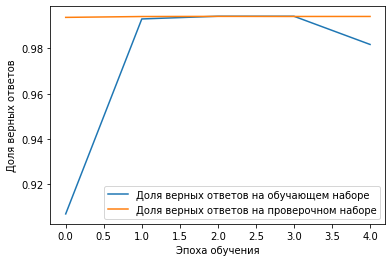

In [ ]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем набор данных для тестирования

In [ ]:
test_comments = pd.read_csv('test.csv')

In [ ]:
test_comments[:10]

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [ ]:
test_labels = pd.read_csv('test_labels.csv')

In [ ]:
test_labels[:10]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


In [ ]:
test_full = pd.merge(test_comments, test_labels, on='id')

In [ ]:
test_full

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1


In [ ]:
test = test_full[test_full['toxic']!=-1]

In [ ]:
test

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


Преобразуем комментарии в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['comment_text'])

In [ ]:
x_test = pad_sequences(test_sequences, maxlen=max_comment_len)

In [ ]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  127,    6,   12, 1085,    7,   67,  101, 1092,    3,    6,
           4,   47,   14,  360,  175,  137],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        1050,  559,   13,  293,    8, 3327],
       [  74,   18, 1315,  294, 1055,    2,    1, 5799, 1081,    4,   75,
          33,    6, 1498, 2804,   76,    1,  250, 1071,  562,  280, 6796,
        5670,  258,  173,   50,  272,   76, 1435,   15,    1, 4063,   12,
        2326,    1,   77, 4101,   10,    1,  694,   23,    9,   52,    8,
         846,  800,   

Правильные ответы

In [ ]:
y_test = test[['toxic',	'severe_toxic',	'obscene', 'threat',	'insult',	'identity_hate']]

In [ ]:
y_test[:10]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0,0,0,0,0,0
7,0,0,0,0,0,0
11,0,0,0,0,0,0
13,0,0,0,0,0,0
14,0,0,0,0,0,0
16,0,0,0,0,0,0
17,0,0,0,0,0,0
19,0,0,0,0,0,0
21,1,0,0,0,0,0
22,0,0,0,0,0,0


## Оцениваем качество работы сети на тестовом наборе данных

In [ ]:
model_lstm.load_weights(model_lstm_save_path)

In [ ]:
model_lstm.evaluate(x_test, y_test, verbose=1)

2000/2000 [==============================] - 10s 5ms/step - loss: 0.0744 - accuracy: 0.9976 - auc: 0.9645


[0.07438363134860992, 0.9975616335868835, 0.9645270109176636]

## Пробуем классифицировать комментарии

In [ ]:
  comment = "X-BOX 360 SUKCS BIG BUMM AND LIKES IT UP THE ASS"

In [ ]:
sequence = tokenizer.texts_to_sequences([comment])

In [ ]:
sequence

[[977, 926, 7883, 462, 4, 2272, 11, 76, 1, 417]]

In [ ]:
data = pad_sequences(sequence, maxlen=max_comment_len)

In [ ]:
data

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  977,  926, 7883,  462,
           4, 2272,   11,   76,    1,  417]], dtype=int32)

In [ ]:
result = model_lstm.predict(data)

In [ ]:
result

array([[0.93577635, 0.05646498, 0.63453263, 0.02494773, 0.59398603,
        0.07905076]], dtype=float32)